In [2]:
import pandas as pd
df = pd.read_csv("your_own_address_for_your_dataset/sales_data.csv")

df


,date,location,product_type,current_inventory,demand_rate,lead_time,order_cost,unit_cost,quantity_sold,sales_price,total_sales
0,2020-01-01,Germany,1000mm BBQ,338,0.456181,40,57000.0,3080.0,2,4004.0,8008.0
1,2020-01-01,Germany,600mm BBQ,104,0.412399,40,33750.0,2020.0,0,2626.0,0.0
2,2020-01-01,Germany,Gas Rob (2 Burners),735,0.398586,30,22400.0,800.0,2,1040.0,2080.0
3,2020-01-01,Germany,Beer Fridge,181,0.387714,60,37000.0,2310.0,1,3003.0,3003.0
4,2020-01-01,Spain,1000mm BBQ,92,0.428707,40,57000.0,3080.0,0,4004.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
30643,2023-06-30,Portugal,Beer Fridge,664,0.316236,60,37000.0,2310.0,1,3003.0,3003.0
30644,2023-06-30,UK,1000mm BBQ,512,0.418184,40,57000.0,3080.0,2,4004.0,8008.0
30645,2023-06-30,UK,600mm BBQ,730,0.411240,40,33750.0,2020.0,1,2626.0,2626.0
30646,2023-06-30,UK,Gas Rob (2 Burners),352,0.392438,30,22400.0,800.0,0,1040.0,0.0


In [3]:
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df = df.drop("date", axis=1)

grouped_df = df.groupby(['year', 'month', 'product_type', 'location']).agg({
    'lead_time': 'first',
    'order_cost': 'first',
    'unit_cost': 'first',
    'sales_price': 'first',
    'current_inventory': 'sum',
    'demand_rate': 'sum',
    'quantity_sold': 'sum',
    'total_sales': 'sum'
}).reset_index()

from sklearn.preprocessing import LabelEncoder
# Encode categorical features using LabelEncoder
product_type_encoder = LabelEncoder()
location_encoder = LabelEncoder()
grouped_df["product_type_encoded"] = product_type_encoder.fit_transform(grouped_df["product_type"])
grouped_df["location_encoded"] = location_encoder.fit_transform(grouped_df["location"])

product_type_mapping = dict(zip(range(len(product_type_encoder.classes_)), product_type_encoder.classes_))
location_mapping = dict(zip(range(len(location_encoder.classes_)), location_encoder.classes_))

grouped_df.drop(["product_type", "location"], axis=1, inplace=True)

grouped_df


,year,month,lead_time,order_cost,unit_cost,sales_price,current_inventory,demand_rate,quantity_sold,total_sales,product_type_encoded,location_encoded
0,2020,1,40,57000.0,3080.0,4004.0,15333,12.002306,26,104104.0,0,0
1,2020,1,40,57000.0,3080.0,4004.0,14491,12.004121,46,184184.0,0,1
2,2020,1,40,57000.0,3080.0,4004.0,15275,12.295798,33,132132.0,0,2
3,2020,1,40,57000.0,3080.0,4004.0,14561,12.099459,37,148148.0,0,3
4,2020,1,40,57000.0,3080.0,4004.0,15853,12.702993,31,124124.0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
1003,2023,6,30,22400.0,800.0,1040.0,16148,11.870603,26,27040.0,3,1
1004,2023,6,30,22400.0,800.0,1040.0,15060,11.814625,33,34320.0,3,2
1005,2023,6,30,22400.0,800.0,1040.0,17856,11.582002,28,29120.0,3,3
1006,2023,6,30,22400.0,800.0,1040.0,15815,11.884113,28,29120.0,3,4


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Split the data into training and testing sets
X = grouped_df.drop(['total_sales'], axis=1)  # Features
y = grouped_df['total_sales']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define evaluation metrics
def evaluate_predictions(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

# Initialize models
linear_reg = LinearRegression()
random_forest = RandomForestRegressor()
xgboost = XGBRegressor()

# Train and evaluate models
models = [linear_reg, random_forest, xgboost]
results = {}

for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse, mae, r2 = evaluate_predictions(y_test, y_pred)
    results[model.__class__.__name__] = {'MSE': mse, 'MAE': mae, 'R^2': r2}

# Print results
for model_name, metrics in results.items():
    print(f'{model_name}:')
    print(f'MSE: {metrics["MSE"]:.2f}')
    print(f'MAE: {metrics["MAE"]:.2f}')
    print(f'R^2: {metrics["R^2"]:.2f}')
    print('---')

# Select the best model based on a specific metric
best_model = min(results, key=lambda x: results[x]['MSE'])
print(f'The best model is: {best_model}')


LinearRegression:
MSE: 24482827.63
MAE: 3286.70
R^2: 0.98
---
RandomForestRegressor:
MSE: 141130.88
MAE: 113.69
R^2: 1.00
---
XGBRegressor:
MSE: 302347.62
MAE: 235.01
R^2: 1.00
---
The best model is: RandomForestRegressor


In [6]:
from itertools import product

# Step 2: Create a list of all unique combinations of product_type_encoded and location_encoded
unique_combinations = list(product(grouped_df['product_type_encoded'].unique(), grouped_df['location_encoded'].unique()))

# Step 3: Create an empty list to store the data for the missing months
missing_data = []

# Step 4: Loop through each unique combination and calculate the mean values for the missing months
for product_type, location in unique_combinations:
    historical_data = grouped_df[(grouped_df['product_type_encoded'] == product_type) & (grouped_df['location_encoded'] == location)]
    historical_data_mean = historical_data.groupby('month').mean()
    historical_data_mean['year'] = 2023
    historical_data_mean['product_type_encoded'] = product_type
    historical_data_mean['location_encoded'] = location
    missing_data.append(historical_data_mean)

# Step 5: Append the calculated values to the list
missing_months_df = pd.concat(missing_data).reset_index()

# Step 6: Create the final DataFrame containing the missing months' data
grouped_df_with_missing_months = pd.concat([grouped_df, missing_months_df], ignore_index=True)

# Sort the final DataFrame by year, month, product_type_encoded, and location_encoded
grouped_df_with_missing_months.sort_values(['year', 'month', 'product_type_encoded', 'location_encoded'], inplace=True)

# Reset the index of the final DataFrame
grouped_df_with_missing_months.reset_index(drop=True, inplace=True)

# Make the predictions for the new months and substitute the current created ones by the new ones:

# Split the DataFrame into historical data (up to the end of month 6) and new months (months 7 to 12)
historical_data = grouped_df_with_missing_months[grouped_df_with_missing_months['month'] <= 6]
new_months_data = grouped_df_with_missing_months[grouped_df_with_missing_months['month'] >= 7]

# Separate the target variable (total_sales) from the features for historical data
X_train = historical_data.drop(columns=['total_sales'])
y_train = historical_data['total_sales']

# Separate the features for new months
X_new_months = new_months_data.drop(columns=['total_sales'])

# Train the Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions for the total sales in new months (months 7 to 12)
predicted_total_sales = rf_model.predict(X_new_months)

# Substitute the predicted values in the DataFrame for months 7 to 12
grouped_df_with_missing_months.loc[grouped_df_with_missing_months['month'] >= 7, 'total_sales'] = predicted_total_sales


In [7]:
grouped_df_with_missing_months

,year,month,lead_time,order_cost,unit_cost,sales_price,current_inventory,demand_rate,quantity_sold,total_sales,product_type_encoded,location_encoded
0,2020,1,40.0,57000.0,3080.0,4004.0,15333.000000,12.002306,26.000000,104104.0,0,0
1,2020,1,40.0,57000.0,3080.0,4004.0,14491.000000,12.004121,46.000000,184184.0,0,1
2,2020,1,40.0,57000.0,3080.0,4004.0,15275.000000,12.295798,33.000000,132132.0,0,2
3,2020,1,40.0,57000.0,3080.0,4004.0,14561.000000,12.099459,37.000000,148148.0,0,3
4,2020,1,40.0,57000.0,3080.0,4004.0,15853.000000,12.702993,31.000000,124124.0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
1291,2023,12,30.0,22400.0,800.0,1040.0,15422.666667,12.148094,33.666667,34951.8,3,1
1292,2023,12,30.0,22400.0,800.0,1040.0,14710.000000,12.269932,29.666667,31028.4,3,2
1293,2023,12,30.0,22400.0,800.0,1040.0,14785.333333,12.198801,29.000000,30147.0,3,3
1294,2023,12,30.0,22400.0,800.0,1040.0,15654.666667,12.111978,30.000000,31202.6,3,4


In [8]:
# Reverting LabelEncoded values back to their original names
grouped_df_with_missing_months['product_type_encoded'] = grouped_df_with_missing_months['product_type_encoded'].map(product_type_mapping)
grouped_df_with_missing_months['location_encoded'] = grouped_df_with_missing_months['location_encoded'].map(location_mapping)


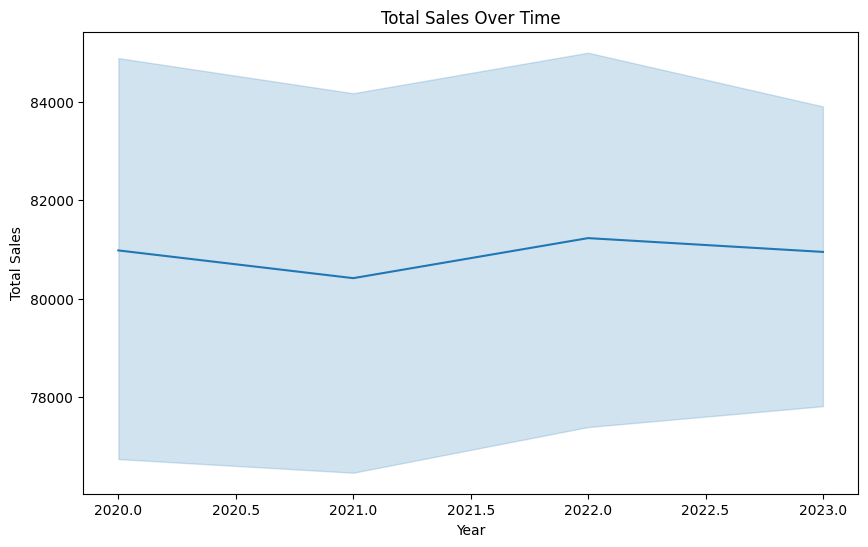

Plot 1: Line Plot for Total Sales Over Time
This plot shows how total sales have evolved over the years. The x-axis represents the year, and the y-axis represents the total sales.


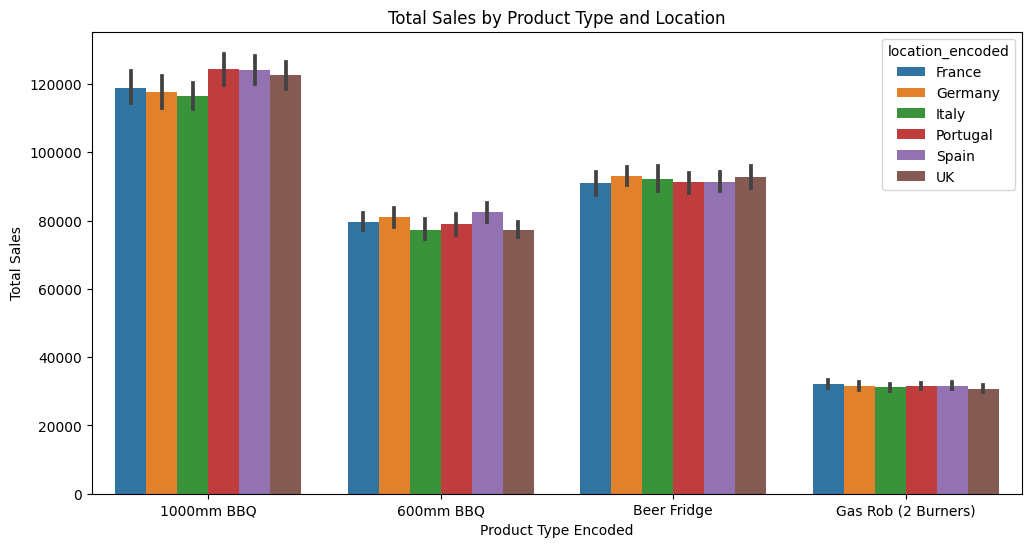

Plot 2: Bar Plot for Total Sales by Product Type and Location
This plot displays the total sales for different product types, categorized by location. The x-axis represents the encoded product types, and the y-axis represents the total sales.


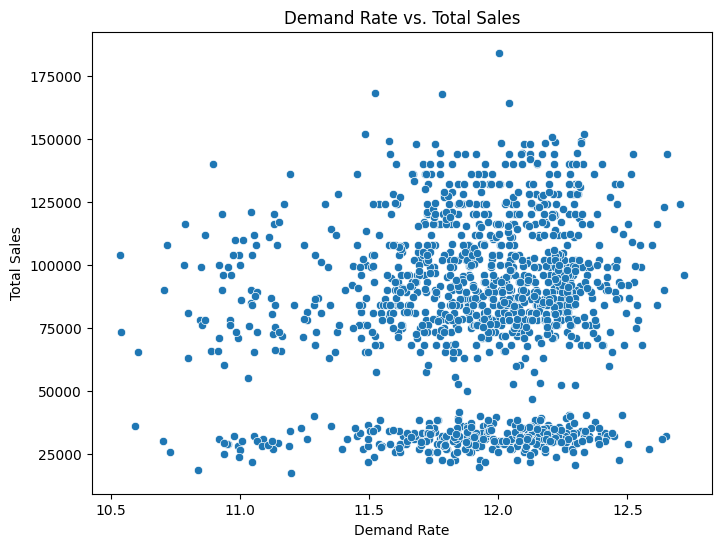

Plot 3: Scatter Plot for Demand Rate vs. Total Sales
This plot shows the relationship between the demand rate and total sales. Each point represents a combination of demand rate and total sales for a specific product and location.


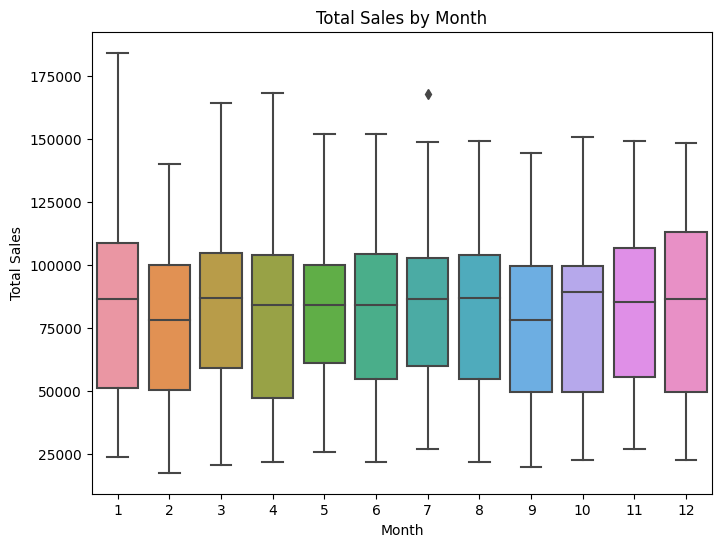

Plot 4: Box Plot for Total Sales by Month
This box plot displays the distribution of total sales for each month across all years in the dataset. The x-axis represents the months (1 to 12), and the y-axis represents the total sales. The box plot shows the median (line inside the box), interquartile range (box), and the overall distribution of the total sales for each month. It doesn't specify any particular year; instead, it provides an overview of the sales distribution for each month regardless of the year.


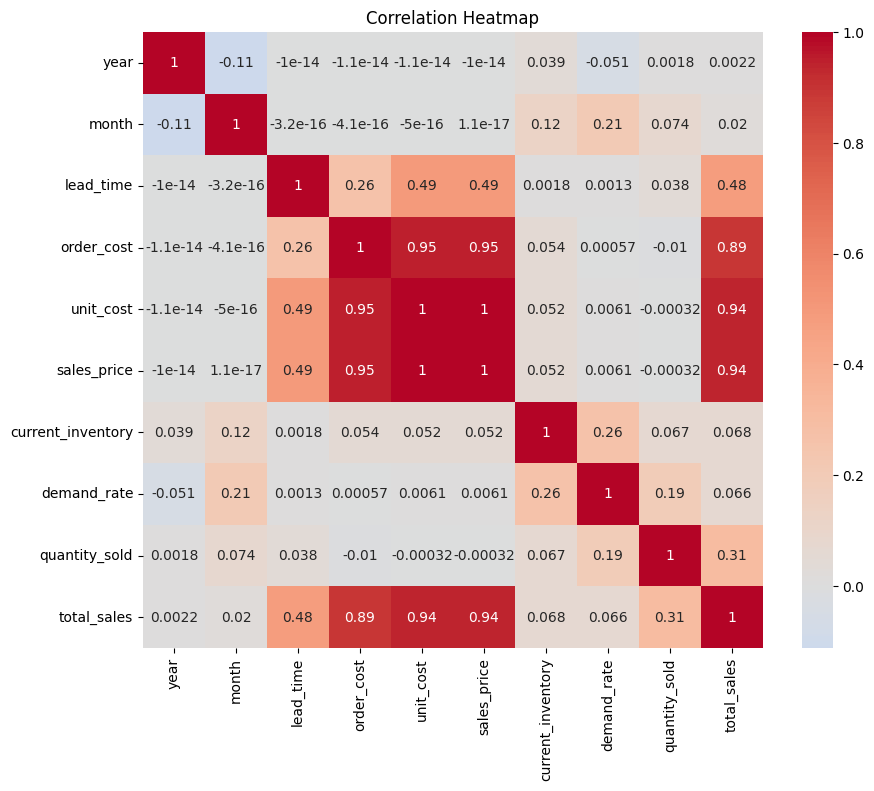

Plot 5: Heatmap for Correlation between Features
This heatmap shows the correlation between different numeric features in the dataset. The darker colors indicate higher positive or negative correlations.


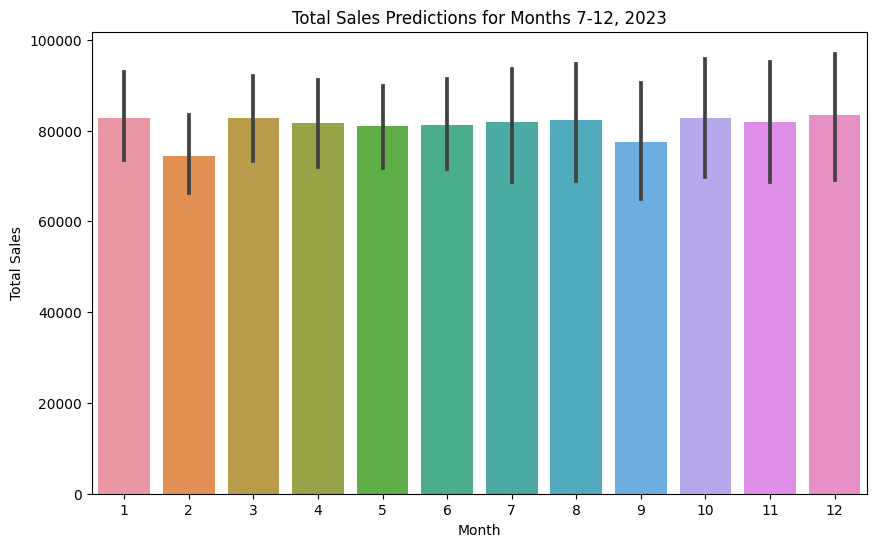

Plot 6: Bar Plot for Total Sales Predictions
This bar plot displays the predicted total sales for the months 7 to 12 of the year 2023 and the real sales from 1 to 6 of 2023. The x-axis represents the month, and the y-axis represents the total sales.


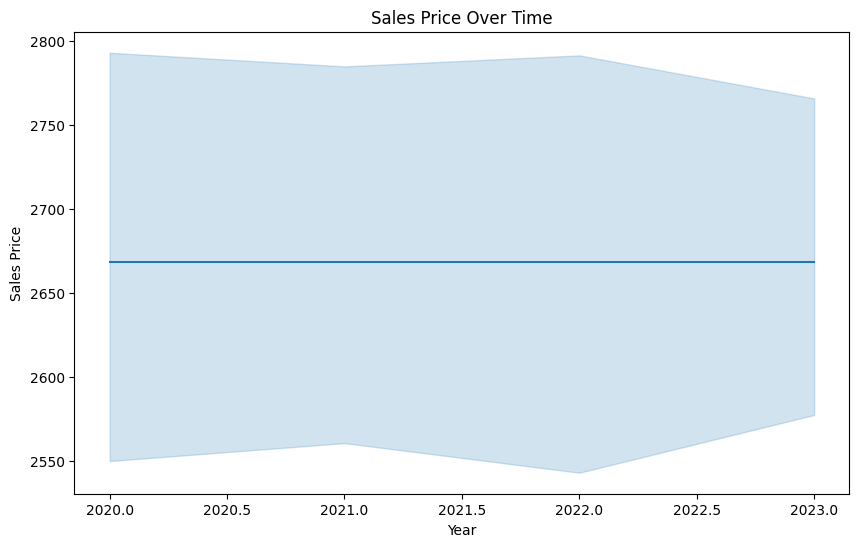

Plot 7: Line Plot for Sales Price Over Time
The line plot in Plot 7 displays the trends of sales prices over the years. The straight line slightly above 2650 represents the average sales price over time. However, there is a blue field around the line, which is the confidence interval or the standard error around the mean. The confidence interval shows the uncertainty or the range within which the true sales price for each year is likely to fall. The blue field helps to visualize the variability or uncertainty in the sales prices. The wider the blue field, the higher the uncertainty, and the narrower the blue field, the more confident we are about the sales price estimate. In summary, the straight line represents the mean sales price, and the blue field around the line represents the confidence interval, indicating the range of possible values for the sales price.


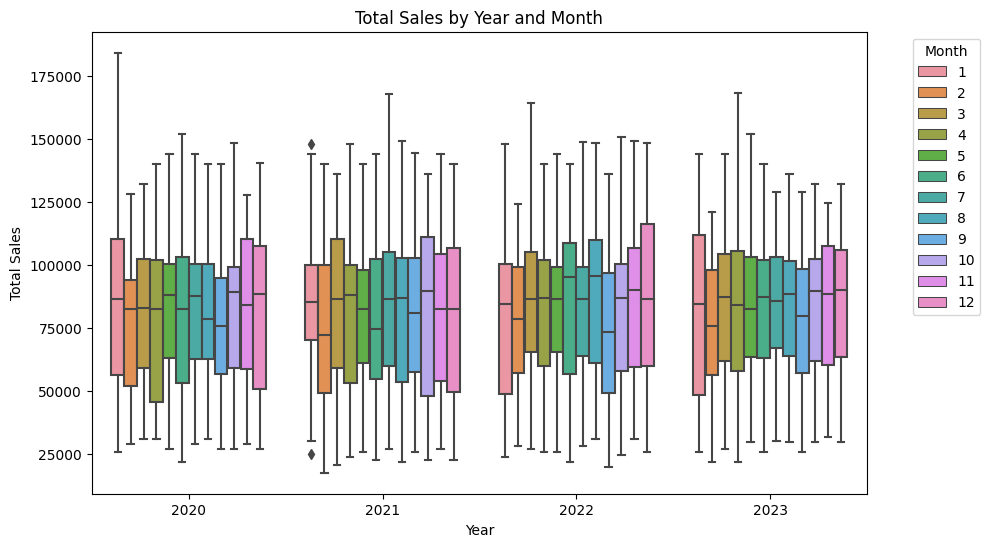

Plot 8: Box Plot for Total Sales by Year and Month
This box plot displays the distribution of total sales for each year, categorized by month. The x-axis represents the year, and the y-axis represents the total sales.


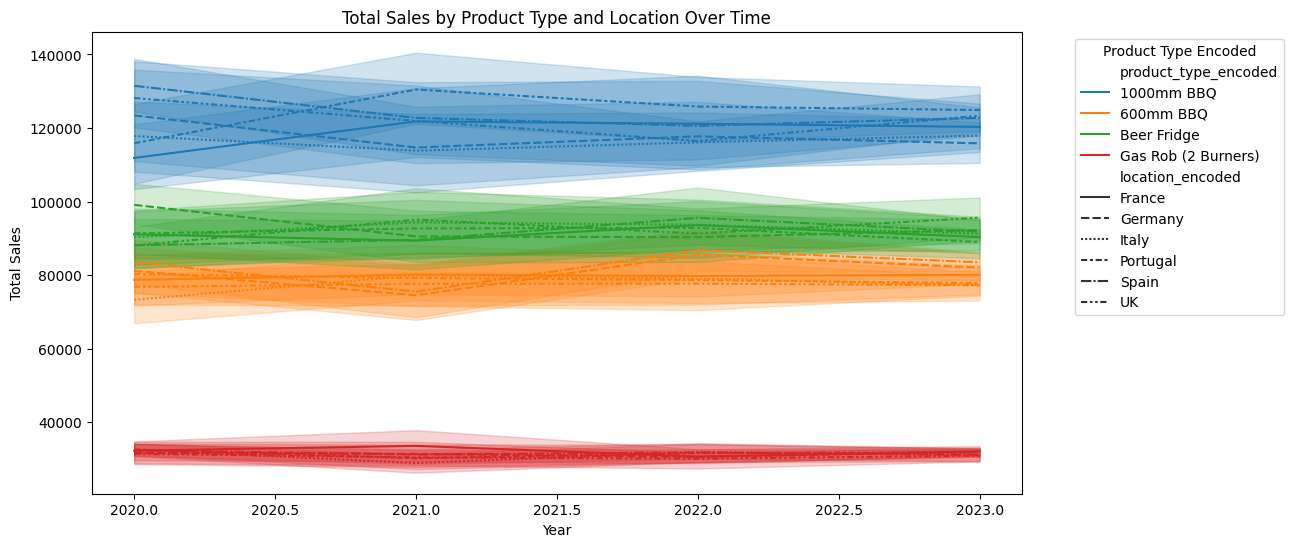

Plot 9: Line Plot for Total Sales by Product Type and Location Over Time
This line plot displays how total sales have evolved over the years for different product types, categorized by location.


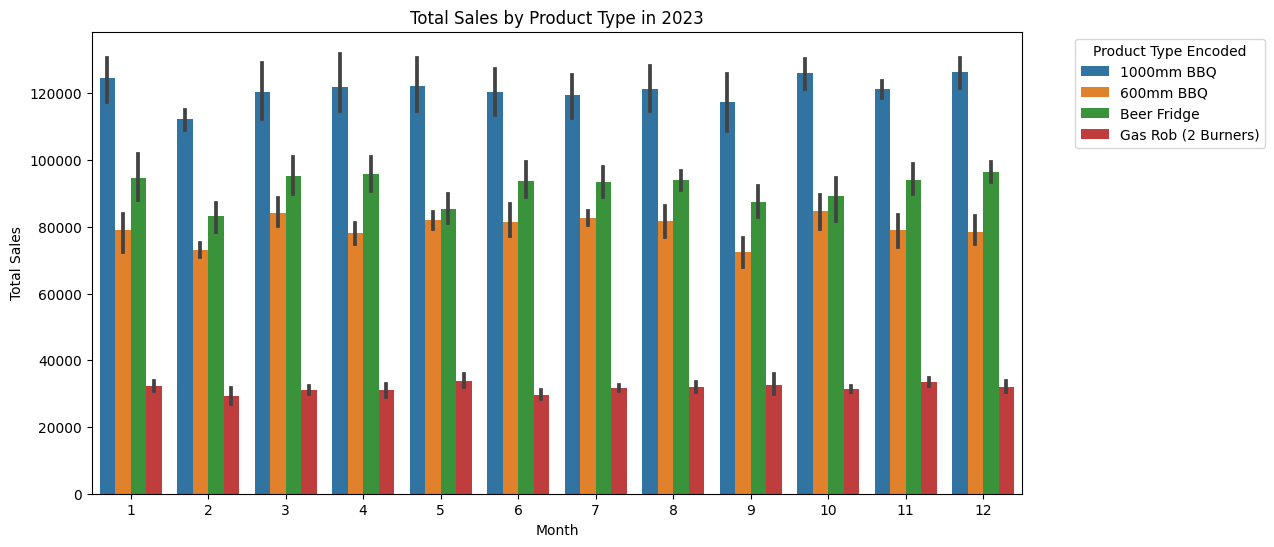

Plot 10: Bar Plot for Total Sales by Product Type in 2023
This bar plot displays the total sales for each product type in the year 2023. The x-axis represents the months, and the y-axis represents the total sales. Each bar represents a product type, and different colors represent different product types.


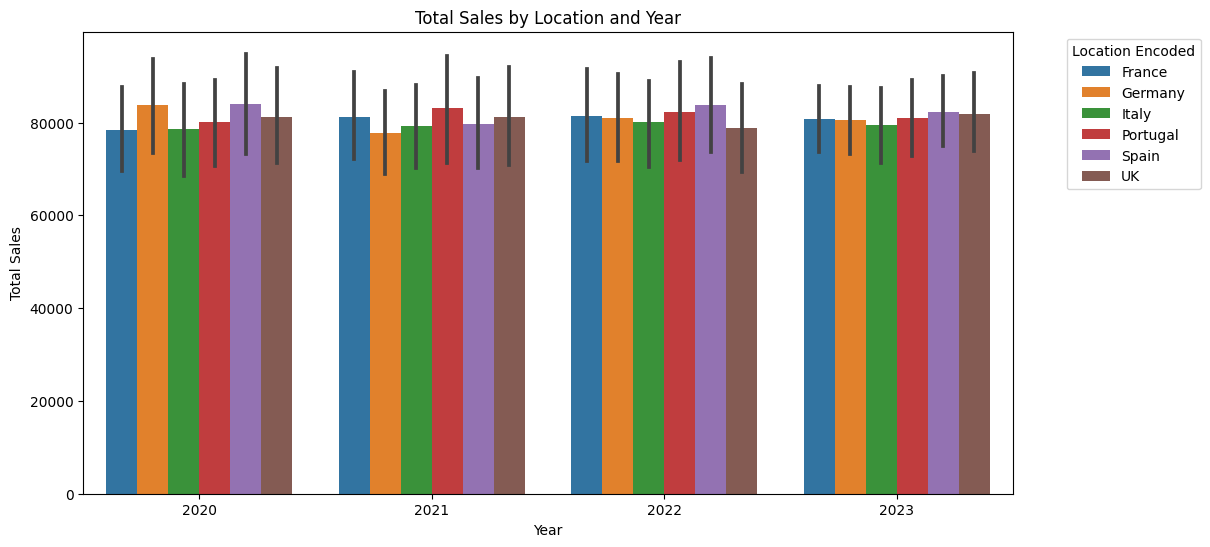

Plot 11: Bar Plot for Total Sales by Location and Year
This bar plot displays the total sales for each location in different years. The x-axis represents the years, and the y-axis represents the total sales. Each bar represents a location, and different colors represent different locations.


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Plot 1: Line Plot for Total Sales Over Time
plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='total_sales', data=grouped_df_with_missing_months)
plt.title('Total Sales Over Time')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.show()
print("Plot 1: Line Plot for Total Sales Over Time")
print("This plot shows how total sales have evolved over the years. The x-axis represents the year, and the y-axis represents the total sales.")

# Plot 2: Bar Plot for Total Sales by Product Type and Location
plt.figure(figsize=(12, 6))
sns.barplot(x='product_type_encoded', y='total_sales', hue='location_encoded', data=grouped_df_with_missing_months)
plt.title('Total Sales by Product Type and Location')
plt.xlabel('Product Type Encoded')
plt.ylabel('Total Sales')
plt.show()
print("Plot 2: Bar Plot for Total Sales by Product Type and Location")
print("This plot displays the total sales for different product types, categorized by location. The x-axis represents the encoded product types, and the y-axis represents the total sales.")

# Plot 3: Scatter Plot for Demand Rate vs. Total Sales
plt.figure(figsize=(8, 6))
sns.scatterplot(x='demand_rate', y='total_sales', data=grouped_df_with_missing_months)
plt.title('Demand Rate vs. Total Sales')
plt.xlabel('Demand Rate')
plt.ylabel('Total Sales')
plt.show()
print("Plot 3: Scatter Plot for Demand Rate vs. Total Sales")
print("This plot shows the relationship between the demand rate and total sales. Each point represents a combination of demand rate and total sales for a specific product and location.")

# Plot 4: Box Plot for Total Sales by Month
plt.figure(figsize=(8, 6))
sns.boxplot(x='month', y='total_sales', data=grouped_df_with_missing_months)
plt.title('Total Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()
print("Plot 4: Box Plot for Total Sales by Month")
print("This box plot displays the distribution of total sales for each month across all years in the dataset. The x-axis represents the months (1 to 12), and the y-axis represents the total sales. The box plot shows the median (line inside the box), interquartile range (box), and the overall distribution of the total sales for each month. It doesn't specify any particular year; instead, it provides an overview of the sales distribution for each month regardless of the year.")

# Plot 5: Heatmap for Correlation between Features
plt.figure(figsize=(10, 8))
# Exclude non-numeric columns from correlation calculation
numeric_columns = grouped_df_with_missing_months.select_dtypes(include=[np.number])
correlation_matrix = numeric_columns.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

print("Plot 5: Heatmap for Correlation between Features")
print("This heatmap shows the correlation between different numeric features in the dataset. The darker colors indicate higher positive or negative correlations.")

# Plot 6: Bar Plot for Total Sales Predictions
plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='total_sales', data=grouped_df_with_missing_months[grouped_df_with_missing_months['year'] == 2023])
plt.title('Total Sales Predictions for Months 7-12, 2023')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()
print("Plot 6: Bar Plot for Total Sales Predictions")
print("This bar plot displays the predicted total sales for the months 7 to 12 of the year 2023 and the real sales from 1 to 6 of 2023. The x-axis represents the month, and the y-axis represents the total sales.")

# Plot 7: Line Plot for Sales Price Over Time
plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='sales_price', data=grouped_df_with_missing_months)
plt.title('Sales Price Over Time')
plt.xlabel('Year')
plt.ylabel('Sales Price')
plt.show()
print("Plot 7: Line Plot for Sales Price Over Time")
print("The line plot in Plot 7 displays the trends of sales prices over the years. The straight line slightly above 2650 represents the average sales price over time. However, there is a blue field around the line, which is the confidence interval or the standard error around the mean. The confidence interval shows the uncertainty or the range within which the true sales price for each year is likely to fall. The blue field helps to visualize the variability or uncertainty in the sales prices. The wider the blue field, the higher the uncertainty, and the narrower the blue field, the more confident we are about the sales price estimate. In summary, the straight line represents the mean sales price, and the blue field around the line represents the confidence interval, indicating the range of possible values for the sales price.")

# Plot 8: Box Plot for Total Sales by Year and Month
plt.figure(figsize=(10, 6))
sns.boxplot(x='year', y='total_sales', hue='month', data=grouped_df_with_missing_months)
plt.title('Total Sales by Year and Month')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
print("Plot 8: Box Plot for Total Sales by Year and Month")
print("This box plot displays the distribution of total sales for each year, categorized by month. The x-axis represents the year, and the y-axis represents the total sales.")

# Plot 9: Line Plot for Total Sales by Product Type and Location
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='total_sales', hue='product_type_encoded', style='location_encoded', data=grouped_df_with_missing_months)
plt.title('Total Sales by Product Type and Location Over Time')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.legend(title='Product Type Encoded', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
print("Plot 9: Line Plot for Total Sales by Product Type and Location Over Time")
print("This line plot displays how total sales have evolved over the years for different product types, categorized by location.")

# Plot 10: Bar Plot for Total Sales by Product Type in 2023
plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='total_sales', hue='product_type_encoded', data=grouped_df_with_missing_months[grouped_df_with_missing_months['year'] == 2023])
plt.title('Total Sales by Product Type in 2023')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend(title='Product Type Encoded', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

print("Plot 10: Bar Plot for Total Sales by Product Type in 2023")
print("This bar plot displays the total sales for each product type in the year 2023. The x-axis represents the months, and the y-axis represents the total sales. Each bar represents a product type, and different colors represent different product types.")

# Plot 11: Bar Plot for Total Sales by Location and Year
plt.figure(figsize=(12, 6))
sns.barplot(x='year', y='total_sales', hue='location_encoded', data=grouped_df_with_missing_months)
plt.title('Total Sales by Location and Year')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.legend(title='Location Encoded', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

print("Plot 11: Bar Plot for Total Sales by Location and Year")
print("This bar plot displays the total sales for each location in different years. The x-axis represents the years, and the y-axis represents the total sales. Each bar represents a location, and different colors represent different locations.")
